In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob

import mne
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP, UnsupervisedSpatialFilter)

mne.set_log_level('warning')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, permutation_test_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA


In [2]:
#plotting parameters

grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 8  # width in inches
fig_height = 6  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1.5,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
    },
)

sns.set_palette(sns.color_palette(nt_colors))

In [3]:
epoch_type = "evoked"
# epoch_type = 'pseudo-rs'

all_participants = [
    "VP07",
    "VP08",
    "VP09",
    "VP10",
    "VP11",
    "VP12",
    "VP13",
    "VP14",
    "VP18",
    "VP19",
    "VP20",
    "VP22",
    "VP23",
    "VP24",
    "VP25",
    "VP26",
    "VP27",
    "VP28",
    "VP29",
    "VP30",
    "VP31",
    "VP32",
    "VP33",
    "VP35",
    "VP36",
    "VP37",
]

path = "/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/"  # icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [45]:
allepochs = []
alllabels = []

for i in all_participants:
    participant = i
    
    folder = path + participant +'/'
    
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif') 
    epochs =  epochs.pick_types(eeg = True) #EOGs break everything\
    epochs = epochs.apply_baseline((None,0))
    
    allepochs.append(epochs)
all_epochs = mne.concatenate_epochs(allepochs)

In [5]:
epochs_ot = all_epochs['PC/on-task/correct/go'].get_data()
epochs_mw = mne.concatenate_epochs([all_epochs['PC/dMW/correct/go'],all_epochs['PC/sMW/correct/go']]).get_data()

In [6]:
labels_ot = np.array(['ot' for i in range(len(epochs_ot))])
labels_mw = np.array(['mw' for i in range(len(epochs_mw))])

In [8]:
X = np.concatenate([epochs_mw, epochs_ot])
y = np.concatenate([labels_mw, labels_ot])

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

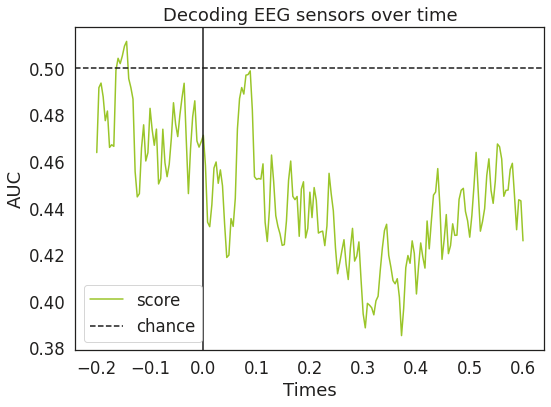

In [46]:
parameters = {'kernel':['rbf'], 'C':[0.001, 0.1,1, 10, 100, 1000, 10000], 'gamma': [1,0.5, 0.1, 0.01, 0.001]}

# clf = make_pipeline(StandardScaler(), Vectorizer(), GridSearchCV(SVC(), parameters, cv=5, n_jobs= 1, verbose = True))
clf = make_pipeline(StandardScaler(), Vectorizer(), SVC())


# pipe = Pipeline(clf)

time_gen = GeneralizingEstimator(clf, n_jobs=-1, scoring='roc_auc',verbose=True)

scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding EEG sensors over time')

plt.savefig('Figs/temp_generalization_ot_vs_mw.png')
plt.show()

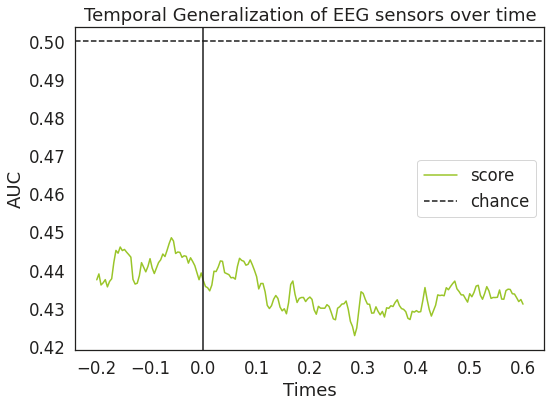

In [44]:
fig, ax = plt.subplots()
ax.plot(epochs.times, np.mean(scores, axis =0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Temporal Generalization of EEG sensors over time')

plt.savefig('Figs/temp_generalization_ot_vs_mw.png')
plt.show()

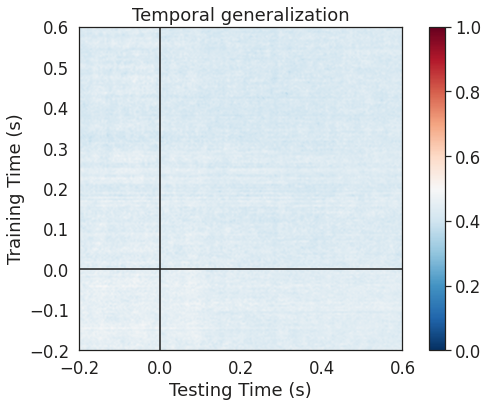

In [43]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

plt.savefig('Figs/temp_generalization_matrix_ot_vs_mw.png')
plt.show()

# dMW vs sMW

In [18]:
epochs_smw = all_epochs['SC/sMW/correct/go'].get_data()
epochs_dmw = all_epochs['SC/dMW/correct/go'].get_data()

In [19]:
labels_smw = np.array(['smw' for i in range(len(epochs_smw))])
labels_dmw = np.array(['dmw' for i in range(len(epochs_dmw))])

In [20]:
X = np.concatenate([epochs_smw, epochs_dmw])
y = np.concatenate([labels_smw, labels_dmw])

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

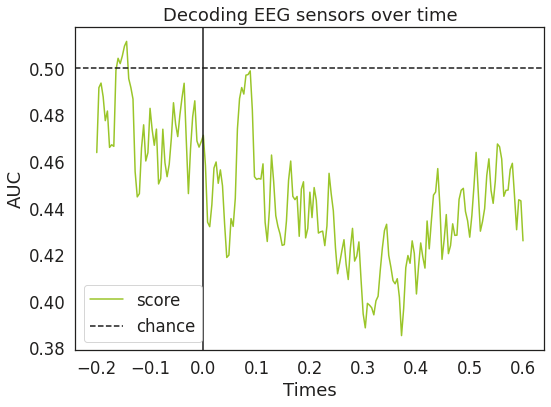

In [21]:
steps = [
    ("scaler", StandardScaler()),
    ('vectorizer', Vectorizer()),
    ("SVM", SVC(kernel="rbf", probability=True)),
]
pipe = Pipeline(steps)

time_gen = GeneralizingEstimator(pipe, n_jobs=-1, scoring='roc_auc',
                                 verbose=True)

scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding EEG sensors over time')

plt.savefig('Figs/temp_generalization_ot_vs_mw.png')
plt.show()

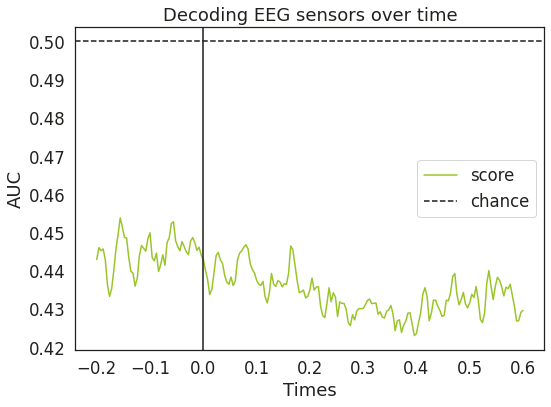

In [22]:
fig, ax = plt.subplots()
ax.plot(epochs.times, np.mean(scores, axis =0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding EEG sensors over time')

plt.savefig('Figs/temp_generalization_ot_vs_mw.png')
plt.show()

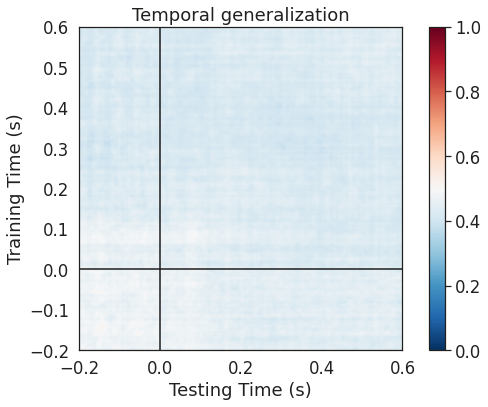

In [23]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

plt.savefig('Figs/temp_generalization_matrix_ot_vs_mw.png')
plt.show()